## Lab # 2
_Tream i_ <br>
Kozlyak Ruslan, Roman Visotskiy, Egor Shmelev

##### Dataset representation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from tqdm import tqdm
import math
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, Lasso, LassoLarsIC, BayesianRidge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import  train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib
import IPython

In [2]:
!pip install bamt

Exception in thread Thread-5 (attachment_entry):
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/debugpy/server/api.py", line 237, in listen
    sock, _ = endpoints_listener.accept()
  File "/usr/lib/python3.10/socket.py", line 293, in accept
    fd, addr = self._accept()
TimeoutError: timed out

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/google/colab/_debugpy.py", line 52, in attachment_entry
    debugpy.listen(_dap_port)
  File "/usr/local/lib/python3.10/dist-packages/debugpy/public_api.py", line 31, in wrapper
    return wrapped(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/debugpy/server/api.py", line 143, in debug
    log.reraise

## We use the following dataset

This document explores a dataset containing prices and attributes for approximately 54,000 round-cut diamonds.
There are 53,940 diamonds in the dataset with 10 features (carat, cut, color, clarity, depth, table, price, x, y, and z). Most variables are numeric in nature, but the variables cut, color, and clarity are ordered factor variables with the following levels.


https://www.kaggle.com/datasets/nancyalaswad90/diamonds-prices

In [6]:
data = pd.read_csv('Diamonds Prices2022.csv', index_col=0)

cut_factor = pd.factorize(data['cut'])
data['cut'] = cut_factor[0]

color_factor = pd.factorize(data['color'])
data['color'] = color_factor[0]

color_factor = pd.factorize(data['clarity'])
data['clarity'] = color_factor[0]

At the moment there is one outlier, since he is the only one it is better to delete it

In [7]:
data[data.isna().any(axis=1)]

,carat,cut,color,clarity,depth,table,price,x,y,z


In [8]:
data = data.dropna()
data[data.isna().any(axis=1)]

,carat,cut,color,clarity,depth,table,price,x,y,z


In [9]:
y = data.price
x = data.drop(['price'], axis='columns')

In [10]:
scaler = StandardScaler()
normalized = scaler.fit_transform(x)

x = pd.DataFrame(normalized, columns = x.columns)

In [11]:
x

,carat,cut,color,clarity,depth,table,x,y,z
0,-1.198189,-0.970782,-1.548314,-1.277166,-0.174033,-1.099673,-1.587882,-1.536239,-1.571166
1,-1.240384,-0.180863,-1.548314,-0.711072,-1.360676,1.585457,-1.641372,-1.658821,-1.741217
2,-1.198189,0.609056,-1.548314,-0.144979,-3.384949,3.375544,-1.498733,-1.457436,-1.741217
3,-1.071605,-0.180863,-1.060551,0.421115,0.454189,0.242892,-1.365010,-1.317342,-1.287749
4,-1.029411,0.609056,-0.572787,-1.277166,1.082412,0.242892,-1.240202,-1.212272,-1.117699
...,...,...,...,...,...,...,...,...,...
53938,0.130941,-0.180863,-0.085024,-1.277166,-0.523046,0.242892,0.373393,0.337515,0.285218
53939,-0.101129,-0.970782,1.378267,-1.277166,0.314584,-1.099673,0.088116,0.118619,0.143509
53940,-0.185518,-0.180863,-1.548314,-0.711072,-0.872059,-1.099673,0.052457,0.004793,-0.069054
53941,-0.185518,-0.180863,0.402740,-0.711072,-1.360676,2.032979,0.007882,-0.003963,-0.154079


In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.25, random_state=42)

#Task formulation for regression. Estimation of multiple correlation

Task is to predict price of diamond depending on its characteristics

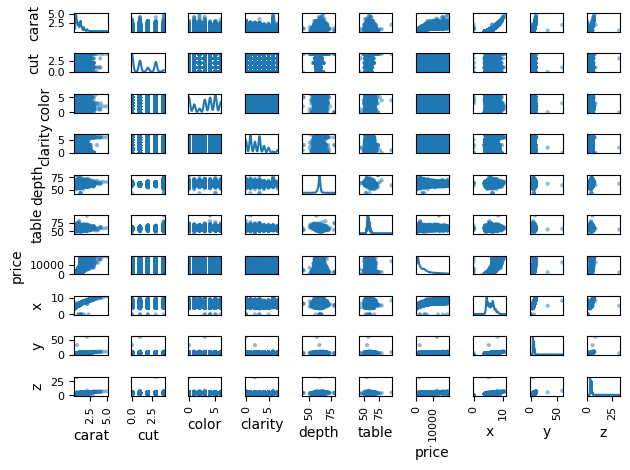

In [ ]:
pd.plotting.scatter_matrix(data, diagonal="kde")
plt.tight_layout()
plt.show()

<AxesSubplot: >

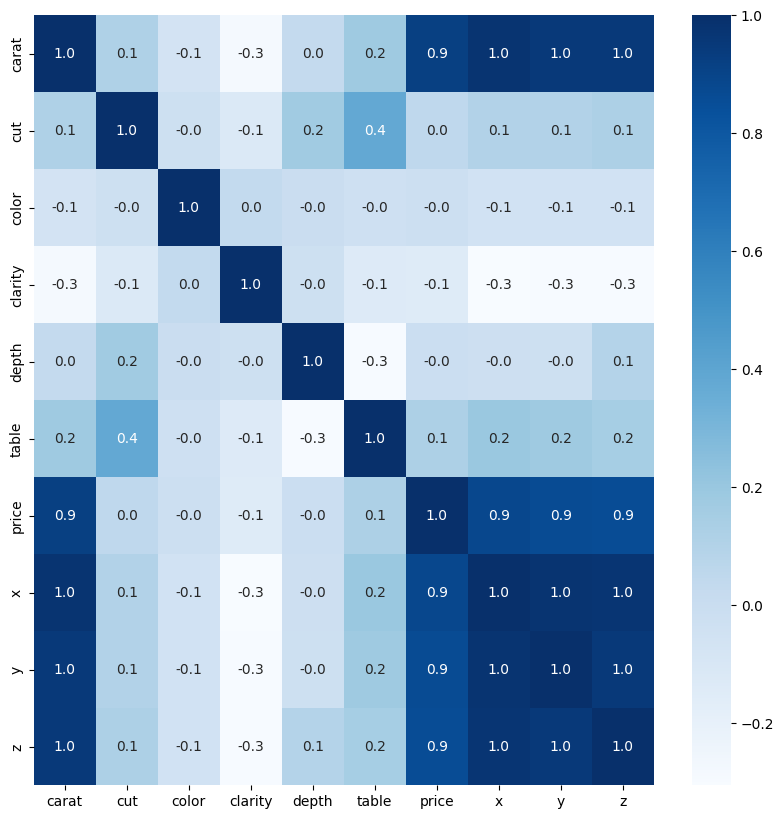

In [ ]:
corr = data.corr()

f, ax = plt.subplots(figsize=(10, 10))

sns.heatmap(corr, annot=True, fmt= '.1f', ax = ax, cmap = 'Blues')

As we can see, the price strongly depends on the carat, as well as the size (x, y, z) of the diamond. Also, in fact, the carat depends on the size, because the larger the diamond, the heavier it is, which means the more carats

# Function for confidence interval estimation

In [13]:
def get_conf_int(alpha, lr, X=X_train, y=Y_train):
    coefs = np.r_[[lr.intercept_], lr.coef_]
    X_aux = X.copy()
    X_aux.insert(0, 'const', 1)
    dof = -np.diff(X_aux.shape)[0]
    mse = np.sum((y - lr.predict(X)) ** 2) / dof
    var_params = np.diag(np.linalg.inv(X_aux.T.dot(X_aux)))
    t_val = stats.t.isf(alpha/2, dof)
    gap = t_val * np.sqrt(mse * var_params)

    return pd.DataFrame({
        'lower': coefs - gap, 'upper': coefs + gap
    }, index=X_aux.columns)

In [14]:
def get_metric_dict(mse, mae, model_name):
  return pd.DataFrame({
      'MSE': round(mse, 2),
      'MAE': round(mae, 2),
  }, index=[model_name])

# Fitting a regression model. Estimation of the confidence interval for the result

# Linear Regression

In [ ]:
alpha = 0.05

lin_model = LinearRegression().fit(X_train, Y_train)

y_pred = lin_model.predict(X_test)

linear_intervals = get_conf_int(alpha, lin_model, X_train, Y_train)

In [ ]:
mae = mean_absolute_error(Y_test, y_pred)
mse = mean_squared_error(Y_test, y_pred)

linear_metrics = get_metric_dict(mse, mae, 'Linear')

# Lasso Regression

In [ ]:
alpha = 0.05

lasso_model = Lasso().fit(X_train, Y_train)

y_pred = lasso_model.predict(X_test)

lasso_intervals = get_conf_int(alpha, lasso_model, X_train, Y_train)

In [ ]:
mae = mean_absolute_error(Y_test, y_pred)
mse = mean_squared_error(Y_test, y_pred)

lasso_metrics = get_metric_dict(mse, mae, 'Lasso')

# Polynomial regression

In [ ]:
poly = PolynomialFeatures(2)
X_train_new = poly.fit_transform(X_train)

poly = PolynomialFeatures(2)
X_test_new = poly.fit_transform(X_test)

reg = LinearRegression().fit(X_train_new, Y_train)

y_pred = reg.predict(X_test_new)

alpha = 0.05

X_train_new = pd.DataFrame(X_train_new, columns=poly.get_feature_names_out())

polynomial_intervals = get_conf_int(alpha, reg, X_train_new, Y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
<ipython-input-12-47c7eedfe678>:9: RuntimeWarning: invalid value encountered in sqrt
  gap = t_val * np.sqrt(mse * var_params)


In [ ]:
mae = mean_absolute_error(Y_test, y_pred)
mse = mean_squared_error(Y_test, y_pred)

polynomial_metrics = get_metric_dict(mse, mae, 'Polynomial')

# Fitting a Bayesian regression model. Estimation of probability interval for prediction

In [ ]:
alpha = 0.05

bayes = BayesianRidge().fit(X_train, Y_train)

y_pred = bayes.predict(X_test)

bayes_intervals = get_conf_int(alpha, bayes, X_train, Y_train)

In [ ]:
mae = mean_absolute_error(Y_test, y_pred)
mse = mean_squared_error(Y_test, y_pred)

bayes_metrics = get_metric_dict(mse, mae, 'Bayessian')

# Combining results

In [ ]:
pd.concat([linear_metrics, lasso_metrics, polynomial_metrics, bayes_metrics])

,MSE,MAE
Linear,1904161.49,838.56
Lasso,1903748.92,839.54
Polynomial,7670998.02,720.84
Bayessian,1904174.91,838.66


In [ ]:
linear_intervals

,lower,upper
const,3922.415033,3950.351692
carat,4786.006249,4916.321015
cut,-120.027293,-88.055036
color,161.936988,190.022499
clarity,437.692265,467.399268
depth,-248.296871,-205.736896
table,-146.143263,-112.462823
x,-1341.558903,-1080.094573
y,-1.852532,110.949705
z,15.586159,252.816422


In [ ]:
lasso_intervals

,lower,upper
const,3922.338366,3950.277650
carat,4743.614070,4873.941077
cut,-118.945449,-86.970188
color,160.432667,188.520816
clarity,438.220257,467.930051
depth,-229.384423,-186.820450
table,-145.687483,-112.003879
x,-1159.490275,-898.001385
y,-14.740246,98.072587
z,-115.018010,122.234537


In [ ]:
polynomial_intervals

,lower,upper
const,NaN,NaN
1,NaN,NaN
carat,3007.503637,3738.023219
cut,-100.970618,-59.706988
color,331.261043,356.774220
clarity,611.237746,640.025218
depth,-66.579395,29.216416
table,-74.336404,-38.480527
x,-1995.668870,-1274.292141
y,2268.319606,2887.612958


In [ ]:
bayes_intervals

,lower,upper
const,3922.415656,3950.352317
carat,4783.656971,4913.971746
cut,-120.017578,-88.045319
color,161.905949,189.991462
clarity,437.745659,467.452665
depth,-247.985897,-205.425919
table,-146.136453,-112.456010
x,-1337.685602,-1076.221253
y,-1.944233,110.858012
z,14.096238,251.326519


# Fitting a Bayesian network

In [15]:
import pandas as pd
from bamt.networks.hybrid_bn import HybridBN
from sklearn import preprocessing as pp
import bamt.preprocessors as preprocessor
from pgmpy.estimators import K2Score
import seaborn as sns

In [16]:
data = pd.read_csv('Diamonds Prices2022.csv', index_col=0)

encoder = pp.LabelEncoder()
discretizer = pp.KBinsDiscretizer(n_bins=10, encode="ordinal", strategy="quantile")
p = preprocessor.Preprocessor([("encoder", encoder), ("discretizer", discretizer)])
discretized_data, est = p.apply(data)

In [17]:
discretized_data

,carat,cut,color,clarity,depth,table,price,x,y,z
1,0,2,1,3,3,1,326,0,0,0
2,0,3,1,2,0,6,326,0,0,0
3,0,1,1,4,0,6,327,0,0,0
4,0,3,5,5,7,4,334,0,0,0
5,1,1,6,3,9,4,335,0,0,1
...,...,...,...,...,...,...,...,...,...,...
53939,5,3,4,3,2,4,2757,6,6,5
53940,5,2,0,3,6,1,2757,5,5,5
53941,5,3,1,2,1,1,2756,5,5,4
53942,5,3,2,2,0,6,2756,5,5,4


In [18]:
p.info

{'types': {'carat': 'cont',
  'cut': 'disc',
  'color': 'disc',
  'clarity': 'disc',
  'depth': 'cont',
  'table': 'cont',
  'price': 'disc_num',
  'x': 'cont',
  'y': 'cont',
  'z': 'cont'},
 'signs': {'carat': 'pos',
  'depth': 'pos',
  'table': 'pos',
  'x': 'pos',
  'y': 'pos',
  'z': 'pos'}}

# BN with HC optimizer

In [19]:
bn = HybridBN(has_logit=False, use_mixture=False)
bn.add_nodes(p.info)
bn.add_edges(discretized_data)

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [20]:
file_name = 'Structure_With_HC.html'
bn.plot(file_name)
IPython.display.HTML(filename=file_name)

## As we can see from the result of the network, the carat really depends on the size of the diamond (x, y, z)

In [ ]:
bn.fit_parameters(data)
sample = bn.sample(3)
sample

100%|██████████| 3/3 [00:00<00:00, 293.68it/s]


,cut,clarity,price,y,color,x,depth,z,table,carat
0,Premium,VS1,7244,6.445044,F,6.560359,62.547781,3.923191,57.337553,1.270958
1,Ideal,VS2,605,4.195842,F,3.859367,62.584995,2.410638,52.957768,0.047528
2,Ideal,VS1,2459,5.863840,G,5.781674,61.827033,3.743386,56.508284,0.785083


# BN with Evo optimizer

In [21]:
temp = discretized_data.drop(index=range(1,int(len(discretized_data)/10 * 9 )))

In [22]:
temp

,carat,cut,color,clarity,depth,table,price,x,y,z
48548,5,4,6,2,8,4,1989,4,4,5
48549,5,1,4,5,0,6,1989,5,4,4
48550,4,2,1,2,8,0,1989,4,4,4
48551,4,3,2,5,5,5,1989,3,3,4
48552,3,3,1,4,4,3,1989,3,3,3
...,...,...,...,...,...,...,...,...,...,...
53939,5,3,4,3,2,4,2757,6,6,5
53940,5,2,0,3,6,1,2757,5,5,5
53941,5,3,1,2,1,1,2756,5,5,4
53942,5,3,2,2,0,6,2756,5,5,4


In [33]:
bn = HybridBN(has_logit=False, use_mixture=False)
bn.add_nodes(p.info)
bn.add_edges(discretized_data, optimizer='Evo', scoring_function=('K2',K2Score))

Generations:   2%|▏         | 1/50 [00:00<?, ?gen/s]

2023-10-30 08:50:10,301 - MultiprocessingDispatcher - Number of used CPU's: 2


Generations:   2%|▏         | 1/50 [00:05<?, ?gen/s]

2023-10-30 08:50:15,544 - OptimisationTimer - Composition time: 0.087 min


BrokenProcessPool: ignored

In [ ]:
file_name = 'Structure_With_EVO.html'
bn.plot(file_name)
IPython.display.HTML(filename=file_name)

In [ ]:
bn.fit_parameters(data)
sample = bn.sample(3)
sample

# BN with HC optimizer and AIC  scoring_function

In [25]:
bn = HybridBN(has_logit=False, use_mixture=False)
bn.add_nodes(p.info)
dummy_func = lambda a: 0;
bn.add_edges(discretized_data, scoring_function=('AIC', dummy_func))

ITERATION:  0
Improved Arc Addition:  (0, 4)
Delta Score:  6608171232.155701
Improved Arc Addition:  (1, 6)
Delta Score:  25618922305.3311
Improved Arc Addition:  (2, 6)
Delta Score:  26033743608.5187
Improved Arc Addition:  (3, 6)
Delta Score:  26523700427.9904
ADDING:  (3, 6) 

ITERATION:  1
Improved Arc Addition:  (0, 4)
Delta Score:  6608171232.155701
Improved Arc Addition:  (1, 6)
Delta Score:  20027093952.000004
Improved Arc Addition:  (2, 6)
Delta Score:  30040640928.0
ADDING:  (2, 6) 

ITERATION:  2
Improved Arc Addition:  (0, 4)
Delta Score:  6608171232.155701
Improved Arc Addition:  (1, 6)
Delta Score:  140189657664.0
ADDING:  (1, 6) 

ITERATION:  3
Improved Arc Addition:  (0, 4)
Delta Score:  6608171232.155701
Improved Arc Addition:  (2, 4)
Delta Score:  6662422009.336499
Improved Arc Addition:  (6, 0)
Delta Score:  8358837143.778001
Improved Arc Addition:  (6, 4)
Delta Score:  11154036411.1674
ADDING:  (6, 4) 

ITERATION:  4
Improved Arc Addition:  (0, 4)
Delta Score:  5630

In [26]:
file_name = 'Structure_With_HC_And_AIC.html'
bn.plot(file_name)
IPython.display.HTML(filename=file_name)

In [ ]:
bn.fit_parameters(data)
sample = bn.sample(3)
sample

# BN with HC optimizer and LL  scoring_function

In [27]:
bn = HybridBN(has_logit=False, use_mixture=False)
bn.add_nodes(p.info)
dummy_func = lambda a: 0;
bn.add_edges(discretized_data, scoring_function=('LL', dummy_func))

ITERATION:  0
Improved Arc Addition:  (0, 4)
Delta Score:  6603316362.155701
Improved Arc Addition:  (1, 6)
Delta Score:  23115535561.3311
ADDING:  (1, 6) 

ITERATION:  1
Improved Arc Addition:  (0, 4)
Delta Score:  6603316362.155701
Improved Arc Addition:  (2, 4)
Delta Score:  6659185429.336499
ADDING:  (2, 4) 

ITERATION:  2
Improved Arc Addition:  (0, 5)
Delta Score:  5444033218.1541
Improved Arc Addition:  (1, 0)
Delta Score:  6534352982.354401
Improved Arc Addition:  (1, 7)
Delta Score:  6561996531.2199
Improved Arc Addition:  (1, 8)
Delta Score:  6576254782.74
Improved Arc Addition:  (1, 9)
Delta Score:  6588185156.4609
Improved Arc Addition:  (4, 0)
Delta Score:  6595750759.3083
Improved Arc Addition:  (5, 7)
Delta Score:  6616992644.226
ADDING:  (5, 7) 

ITERATION:  3
Improved Arc Addition:  (0, 5)
Delta Score:  5444033218.1541
Improved Arc Addition:  (1, 0)
Delta Score:  6534352982.354401
Improved Arc Addition:  (1, 8)
Delta Score:  6576254782.74
Improved Arc Addition:  (1, 9)

In [28]:
file_name = 'Structure_With_HC_And_LL.html'
bn.plot(file_name)
IPython.display.HTML(filename=file_name)

In [ ]:
bn.fit_parameters(data)
sample = bn.sample(3)
sample

# Sampling и inference of MAP value. Estimation of credible interval for posterior distribution

# Аnalysis and comparison of point estimations of quality and intervals for regression results